# Постановка задачи

Работаем с синтетическими данными. 

Датасет #1 - смесь нескольких синусоид, без изысков.

Тест максимально похож на тренировочный датасет. 
Цель - добиться успеха на тесте. 

# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import random
import warnings
import ipynbname
import logging.config
import cProfile, pstats

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

gen12.2-Syntethic-Data.01


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

%matplotlib notebook

In [3]:
# NN Frameworks
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, Reshape
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model, clone_model

2023-09-23 18:05:20.960530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# RT packages
from rl import DQNAgent
from env import TradeEnv

from core_v2 import Constructor, Player
from core_v2.data_point import DataPointFactory
from core_v2.observation_builder.precompute import PrecomputeOrderbookDiffFeature

from train_tools import TrainManager, TrainPlot4
from train_tools import plot_and_go, distribution_analysis, get_max_step_factor

In [5]:
seed_value= 0
#os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
#np.random.seed(seed_value)
#tf.random.set_seed(seed_value)

# Датасет

<IPython.core.display.Javascript object>


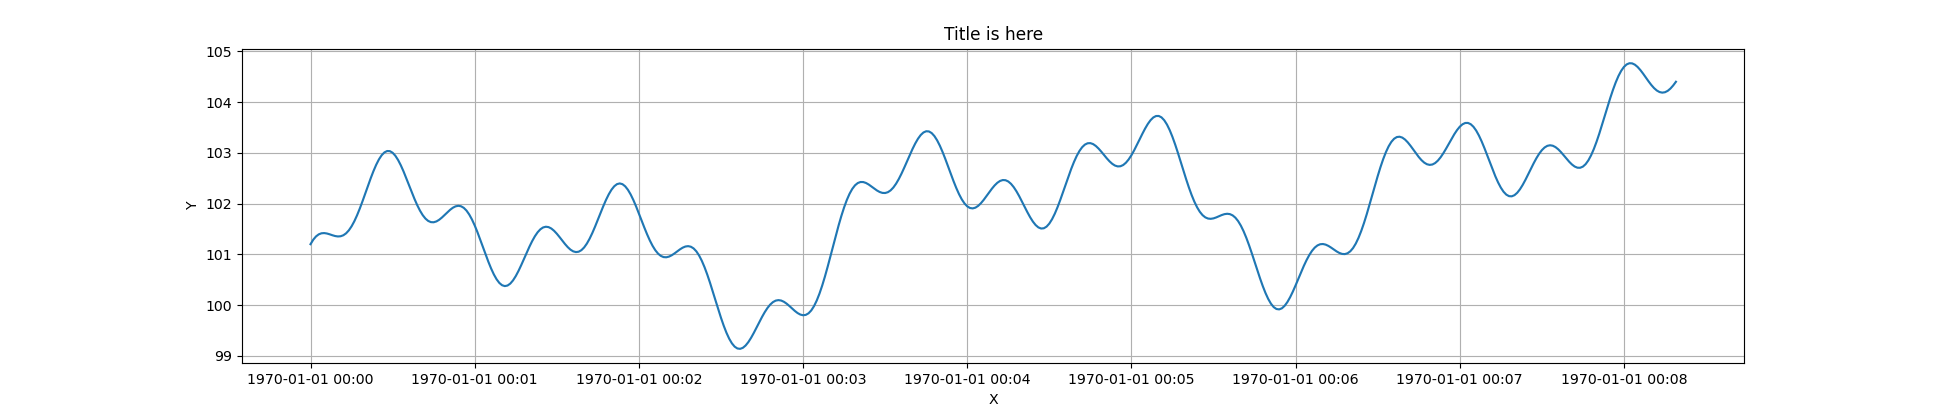

(500, 2)


In [7]:
# train dataset
n_points = 500

main_trend = np.sin(np.linspace(0, 15, n_points)) + np.linspace(0, 3, n_points) *1.0
noise_1 = np.sin(np.linspace(0, 33, n_points)) + np.linspace(1, 0, n_points) *0.7
noise_2 = np.cos(np.linspace(0, 111, n_points))*0.5

area_1 = np.cos(np.linspace(0, 40, 150))*0.
area_2 = np.cos(np.linspace(0, 60, 150))*0.
area_3 = np.cos(np.linspace(0, 200, 100))*0.
area_4 = np.cos(np.linspace(0, 200, 100))*0.
areas = np.concatenate([area_1, area_2, area_3, area_4])

dataset = main_trend + noise_1 + noise_2 + areas

dataset = dataset + 100

raw_data = np.concatenate([dataset.reshape(-1,1), dataset.reshape(-1,1)], axis=1)
data_train = pd.DataFrame(raw_data, columns=["lowest_ask", "highest_bid"], dtype=np.float32)
plot_and_go(data_train, fig_x=19, fig_y=4, dpi=51)

<IPython.core.display.Javascript object>


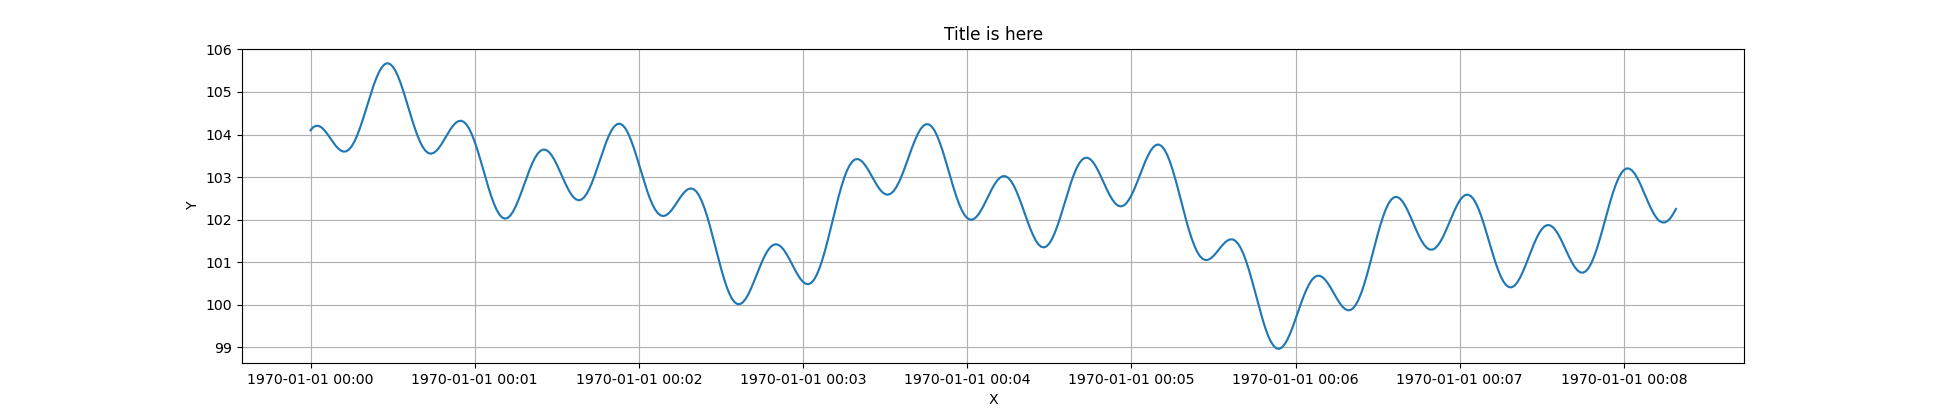

(500, 2)


In [8]:
# test dataset
n_points = 500

main_trend = np.sin(np.linspace(0, 15, n_points)) + np.linspace(3, 1, n_points) *1.0
noise_1 = np.sin(np.linspace(0, 33, n_points)) + np.linspace(1, 0, n_points) *0.3
noise_2 = np.cos(np.linspace(0, 111, n_points))*0.8

area_1 = np.cos(np.linspace(0, 40, 150))*0.
area_2 = np.cos(np.linspace(0, 60, 150))*0.
area_3 = np.cos(np.linspace(0, 200, 100))*0.
area_4 = np.cos(np.linspace(0, 200, 100))*0.
areas = np.concatenate([area_1, area_2, area_3, area_4])

dataset = main_trend + noise_1 + noise_2 + areas

dataset = dataset + 100

raw_data = np.concatenate([dataset.reshape(-1,1), dataset.reshape(-1,1)], axis=1)
data_test = pd.DataFrame(raw_data, columns=["lowest_ask", "highest_bid"], dtype=np.float32)
plot_and_go(data_test, fig_x=19, fig_y=4, dpi=51)

# Инициализация компонентов

## Env

In [10]:
core_config = {
    "action_controller":{"class": "BasicTrainController", "params":{ 
            "penalty": -1, 
            "market_fee": 0, #0.0015,
            "wait_scale": 10, 
            "open_scale": 0, 
            "hold_scale": 10, 
            "close_scale": 10, 
            "last_points_mean": 1
        },},


    "observation_builder":{
        "class": "ObservationBuilder",
        "inputs": [
            {"class": "Input1D", "features": [{"class": "RawContextFeature", "params": {"name":"is_open"}}]},
            {"class": "Input2D", "features": [
                {"class": "RatesFeature", "params": {"step_factor":1, "scale_output": 30}},
                #{"class": "RatesFeature", "params": {"step_factor":3, "scale_output": 40}},
                {"class": "ProfitFeature", "params": {"step_factor":1, "scale_output": 0.5, "normalization":True, "clip_output":2}}
            
            ]}
        ]
    }
}
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
core_constructor = Constructor()
env_core = core_constructor.get_core(ALIAS, core_config)

## Datapoint factory

In [13]:
# Параметры точки наблюдения
observation_len = 20
offset = get_max_step_factor(core_config) * observation_len + 1

dp_factory_config = {
    "observation_len": observation_len,                            # Количество точек наблюдения в сэмпле
    "offset": offset,                                 # Хвост исторических данных
    "future_points": 0,                               # Количество будущех точек для предсказания тренда (временное решение)
    "step_size": 1                                    # Шаг по датасет
 }

dpf_train = DataPointFactory(dataset=data_train, **dp_factory_config, alias='train')
dpf_test = DataPointFactory(dataset=data_test, **dp_factory_config, alias='test')

<IPython.core.display.Javascript object>


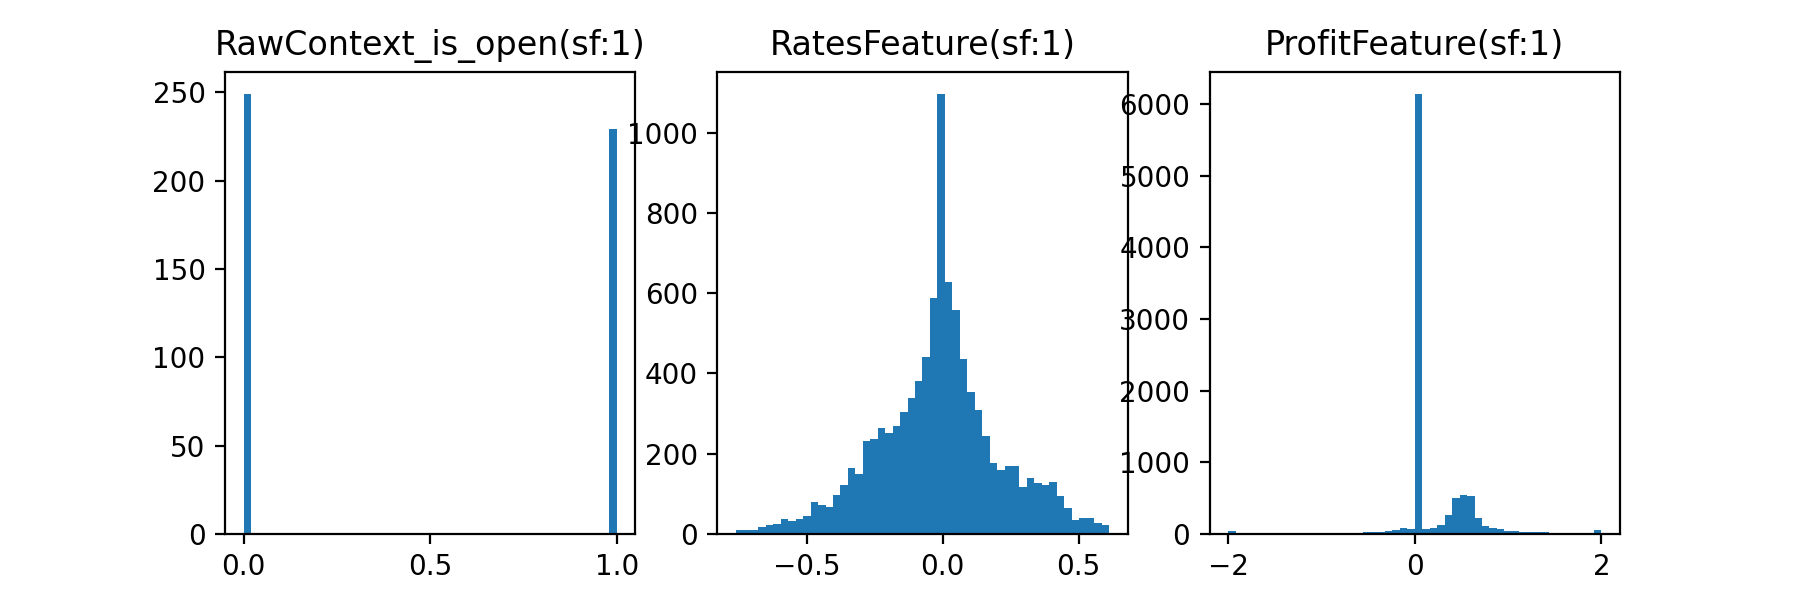

In [14]:
data = distribution_analysis(dpf_train, env_core, trade_every=50, plot_x_size=3, plot_y_size=3)

# Нейронная сеть

In [16]:
ACTIVATION = 'relu'

env = TradeEnv(env_core, dpf_train, alias=ALIAS, log=False, log_obs=False)
def create_q_model(env):
    num_actions = env.action_space
    #----------------------------------------------
    
    inp_static = Input(shape=env.observation_space[0])
    
    inp_timesteps = Input(shape=env.observation_space[1])
    conv_ts = Conv1D(filters=32, kernel_size=5, strides=1, input_shape=env.observation_space[1], activation=ACTIVATION)(inp_timesteps)
    conv_ts = MaxPool1D(pool_size=3)(conv_ts)
    conv_ts = Conv1D(filters=64, kernel_size=3, strides=1, activation=ACTIVATION)(conv_ts)    
    conv_ts = MaxPool1D(pool_size=2)(conv_ts)
    flt_ts = Flatten()(conv_ts)
    concat = Concatenate()([inp_static, flt_ts])
    
    
    #reshaped = Reshape((1,-1))(concat)
    #lstm1 = LSTM(256, activation=ACTIVATION, return_sequences=True, input_shape=())(reshaped)
    #lstm1 = LSTM(64, activation=ACTIVATION, return_sequences=False, input_shape=())(lstm1)
   
    
    classif = Dense(256, activation=ACTIVATION)(concat)
    classif = Dropout(0.3)(classif)
    classif = Dense(256, activation=ACTIVATION)(classif)
    classif = Dropout(0.3)(classif)
    classif = Dense(256, activation=ACTIVATION)(classif)
    classif = Dropout(0.3)(classif)

    output = Dense(num_actions, activation='softmax')(classif)

    model = Model(inputs=[inp_static, inp_timesteps], outputs=output)
    return model
model = create_q_model(env)
model_target = create_q_model(env)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 2)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 32)       352         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 5, 32)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3, 64)        6208        ['max_pooling1d[0][0]']          
                                                                                              

2023-09-23 18:06:16.449046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Обучение

In [17]:
random.seed(seed_value)

core_train = core_constructor.get_core("train", core_config)
env = TradeEnv(core_train, dpf_train, alias=ALIAS, log=False, log_obs=False)

model = create_q_model(env)
model_target = create_q_model(env)
agent = DQNAgent(env, model, model_target)

agent.epsilon_random_frames = 1000   #(5% = 650)
agent.epsilon_greedy_frames = 25000 #(100% = 25000)
agent.max_memory_length     = 25000  #(20% = 2600)
agent.max_steps_per_episode = 50000
agent.gamma = 0.975
agent.epsilon_min = 0.01
agent.batch_size = 32
agent.update_after_actions = 4
agent.update_target_network = 1500   #(1% = 130)
agent.loss_function = tf.keras.losses.Huber() # #tf.keras.losses.Huber() #tf.keras.losses.MeanSquaredError()
agent.optimizer = Adam(learning_rate=0.0001, clipnorm=0.001)    #Adam(learning_rate=learning_rate) RMSprop(learning_rate=learning_rate) SGD(learning_rate=learning_rate)


tp = TrainPlot4()
core_test = core_constructor.get_core("test", core_config)
tm = TrainManager(agent, core_test, dpf_test, tp, alias=ALIAS)

Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


In [29]:
tm.load_snapshot(250000)

[Errno 2] No such file or directory: './train_snapshots/gen12.2-Syntethic-Data.01/snapshots/snapshot.250000.pkl'
Снепшот не найден или поврежден. Что-то прошло не так


In [18]:
tp.init_plot(width=1000, height=800)
tp.update_plot(tm.history)

FigureWidget({
    'data': [{'legendgroup': '1',
              'line': {'color': '#109618', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '6ef5b97e-f06c-46d3-a22e-25ce3c1ef897',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '1',
              'line': {'color': '#FF9900', 'width': 1},
              'mode': 'lines',
              'name': 'Test',
              'type': 'scatter',
              'uid': '62c8aecb-ee51-4e3f-8299-8c15c31ede75',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'legendgroup': '2',
              'line': {'color': '#D62728', 'width': 1},
              'mode': 'lines',
              'name': 'Train',
              'type': 'scatter',
              'uid': '9b5adc8f-642e-43ba-9750-b98ab35695aa',
              'xaxis': 'x2',
              'yaxis': 'y3'},
             {'legendgroup': '2',
              'line': {'color': '#FF9900'

In [19]:
tm.go(max_frames=150000, test_every=500, snapshot_every=50000, update_plot_every=500, save_since=0.15)

18:06:56 Running reward: -236.44  at episode 4    | frame 1500   | eps: 0.94 | Running loss: 0.20037
18:07:21 Running reward: -221.55  at episode 7    | frame 3000   | eps: 0.88 | Running loss: 0.13286
18:07:46 Running reward: -214.42  at episode 10   | frame 4500   | eps: 0.82 | Running loss: 0.10816
18:08:12 Running reward: -209.39  at episode 13   | frame 6000   | eps: 0.76 | Running loss: 0.09571
18:08:38 Running reward: -202.36  at episode 16   | frame 7500   | eps: 0.70 | Running loss: 0.08786
18:09:07 Running reward: -196.91  at episode 19   | frame 9000   | eps: 0.64 | Running loss: 0.08216
18:09:34 Running reward: -189.47  at episode 22   | frame 10500  | eps: 0.58 | Running loss: 0.07791
18:10:02 Running reward: -182.11  at episode 26   | frame 12000  | eps: 0.52 | Running loss: 0.07376
18:10:30 Running reward: -175.04  at episode 29   | frame 13500  | eps: 0.47 | Running loss: 0.07102
18:11:01 Running reward: -165.58  at episode 32   | frame 15000  | eps: 0.41 | Running loss

18:46:39 Running reward: 1.60     at episode 261  | frame 124500 | eps: 0.01 | Running loss: 0.00268
18:47:11 Running reward: 1.49     at episode 264  | frame 126000 | eps: 0.01 | Running loss: 0.00274
18:47:43 Running reward: 1.71     at episode 267  | frame 127500 | eps: 0.01 | Running loss: 0.00274
18:48:14 Running reward: 1.75     at episode 270  | frame 129000 | eps: 0.01 | Running loss: 0.00275
18:48:44 Running reward: 1.88     at episode 274  | frame 130500 | eps: 0.01 | Running loss: 0.00263
18:49:16 Running reward: 2.16     at episode 277  | frame 132000 | eps: 0.01 | Running loss: 0.00269
18:49:44 Running reward: 2.20     at episode 280  | frame 133500 | eps: 0.01 | Running loss: 0.00266
18:50:12 Running reward: 2.28     at episode 283  | frame 135000 | eps: 0.01 | Running loss: 0.00263



KeyboardInterrupt



# Test

In [20]:
tm.get_train_stat()

Profit: 23.20% | id: 96500 | Penalties: 0    | TotalReward: 7.22     Sparsity 0.45
Profit: 23.20% | id: 89500 | Penalties: 0    | TotalReward: 7.17     Sparsity 0.47
Profit: 23.20% | id: 91000 | Penalties: 0    | TotalReward: 7.21     Sparsity 0.44
Profit: 22.97% | id: 93000 | Penalties: 0    | TotalReward: 7.18     Sparsity 0.45
Profit: 22.89% | id: 97500 | Penalties: 0    | TotalReward: 7.08     Sparsity 0.48
Profit: 22.89% | id: 106500 | Penalties: 0    | TotalReward: 7.09     Sparsity 0.45
Profit: 22.88% | id: 90000 | Penalties: 0    | TotalReward: 7.16     Sparsity 0.47
Profit: 22.86% | id: 90500 | Penalties: 0    | TotalReward: 7.06     Sparsity 0.43
Profit: 22.85% | id: 106000 | Penalties: 0    | TotalReward: 7.16     Sparsity 0.43
Profit: 22.84% | id: 91500 | Penalties: 0    | TotalReward: 7.06     Sparsity 0.47
Profit: 22.82% | id: 102000 | Penalties: 0    | TotalReward: 7.15     Sparsity 0.47
Profit: 22.79% | id: 97000 | Penalties: 0    | TotalReward: 7.16     Sparsity 0.48
P

<IPython.core.display.Javascript object>


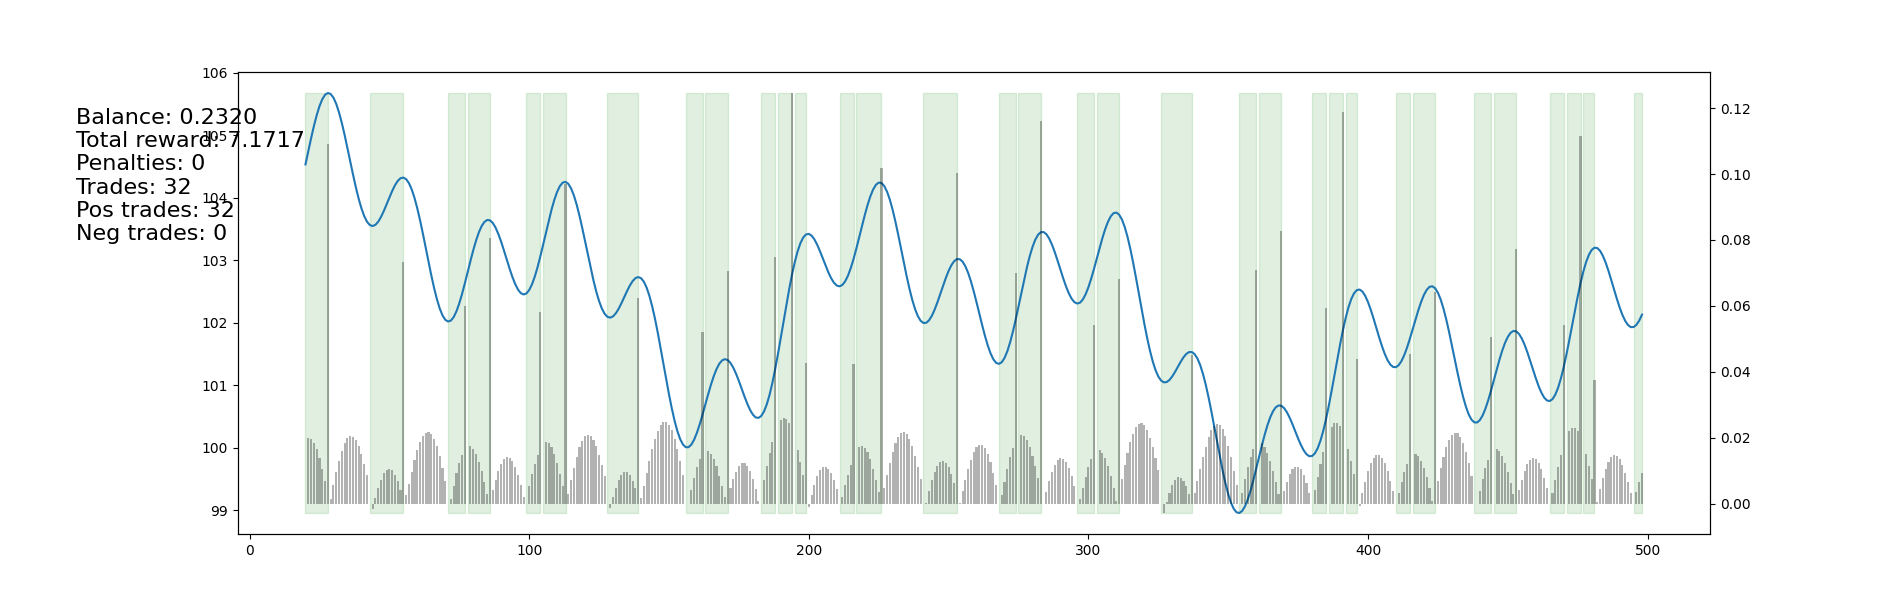

In [21]:
# max_id
model_id = 89500
model_test = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_test, dpf_test)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

<IPython.core.display.Javascript object>


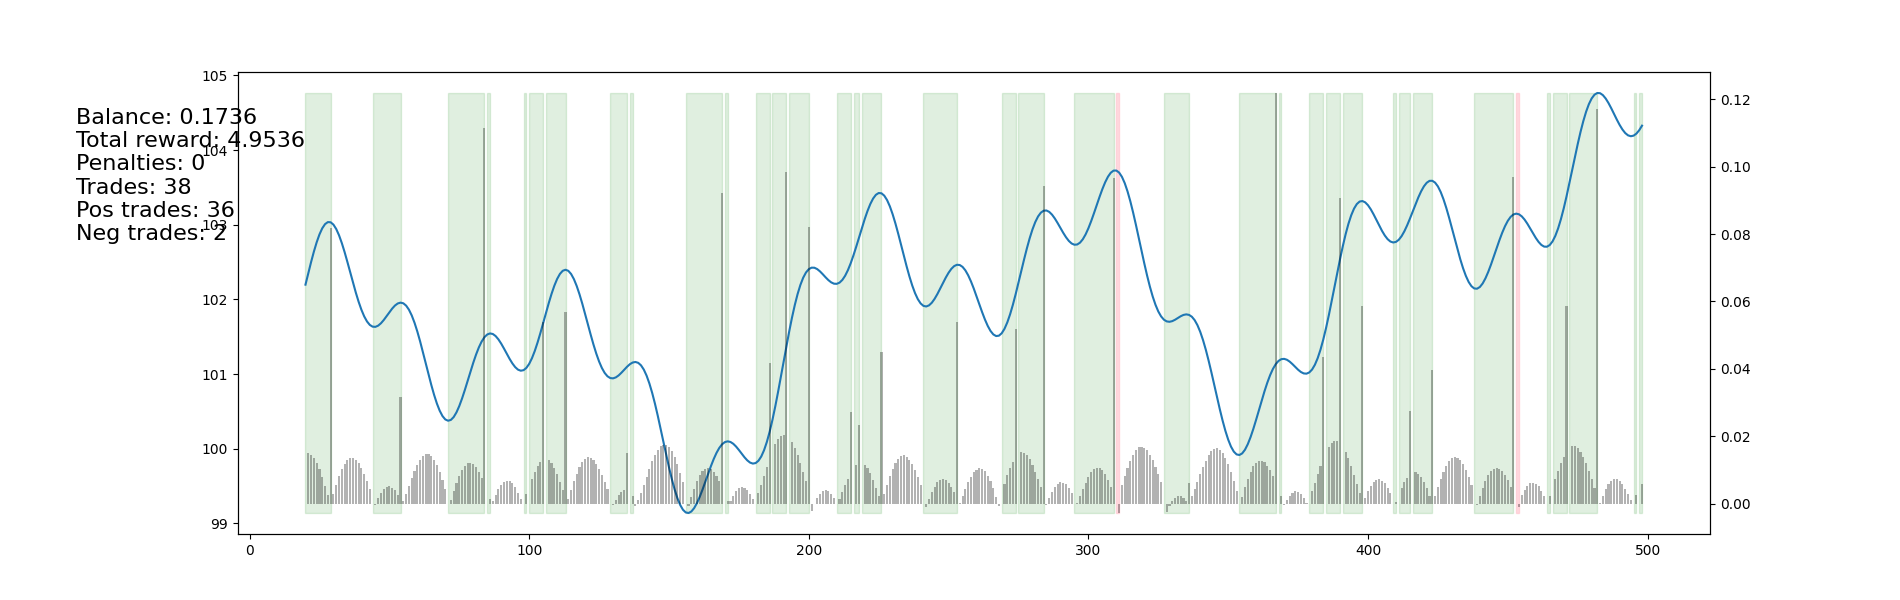

In [22]:
model_id = 89500
model_train = tm.get_model(model_id)
#model_test = agent.model

player = Player(core_test, model_train, dpf_train)
result = player.play(fig_size_x = 19, fig_size_y = 6, dpi = 50, font_size = 16)

## Итоги

Базовый конфиг - смог обучиться и получить лучший результат на тесте, но стабильности не было - встречались колебания (с этим надо бороться).

Конфиг:
 - Датасет: 20 наблюдений
 - Ядро
     - wait=10|open=0|hold=10|close=6
     - num_mean_obs=1, market_fee=0
 - Сеть: 
     - CNN(f96, k5, s1)-MaxPool(3)-CNN(f128, k3, s1)-MaxPool(2)
     - Flatten
     - Dense(256/do=0.3)-Dense(256/do=0.3)-Dense(256/do=0.3)
 - Агент:
     - greedy_frames=25k, random_frames=1000, memory_length=5000, eps_min=0
     - gamma = 0.95, batch_size = 32, uaa=4, utn=500
     - loss=Huber, optimizer=Adam(learning_rate=0.0001, clipnorm=0.001)

----
 - Усложнил классификатор 3x1024: на стабильность не повлияло.
 - utn=1000 - что-то поменялось в лучшую сторону - есть периоды по 10 циклов с плюс-минус одинаковым результатом.Но еще далеко от идеала или намеков на то, что нужно
 - utn=250 - хуже, чем utn=1000, много нестабильности
 - learning_rate=0.00005 - на стабильность не повлияло
 - epsilon_greedy_frames - 12к/25к/50к/100к - не повлияло на стабильность
 - max_memory_length - 2.5k, 5k, 12.5k, 25, 50k - не повлияло на стабильность
 
====
update_target_network = 1500- стабильность стала выше
 - Альтренативная сеть (меньше пулинг, сложнее классификатор) - не повияло на стабильность
     - CNN(f96, k5, s1)-MaxPool(2)-CNN(f128, k3, s1)-MaxPool(2)
     - Flatten
     - Dense(512/do=0.3)-Dense(384/do=0.3)-Dense(256/do=0.3)
 - Изменения в CNN - не повияло на стабильность
     - CNN(f32, k7, s1)-CNN(f64, k5, s1)-MaxPool(2)-CNN(f48, k3, s1)
     - Flatten
     - Dense(256/do=0.3)-Dense(256/do=0.3)-Dense(256/do=0.3)
 - Изменения в CNN2 - не повияло на стабильность
     - CNN(f32, k7, s1)-MaxPool(2)-CNN(f64, k5, s1)-MaxPool(2)
     - Flatten
     - Dense(256/do=0.3)-Dense(256/do=0.3)-Dense(256/do=0.3)
 - dropout=0 - не повлияло
 - dropout=0.5 - не повлияло
 - gamma=0.97 - стало сильно лучше!
 
====

gamma=0.97 - update_target_network = 1500 - стабильность стала выше
 - gamma от 0.93 до 0.995 - при гамма выше 0.97 начинает превалировать более высокая награда при закрытии сделки и сеть начинает часто трейдить, тем самым упуская выгоду от ожидания пика. Это значение имеет смысл при текущих коэффициентах награды.
 
Идеальная комбинация слишком точная и значения параметров были подобраны исходя из компромисса между стабильностью (высокая) и результатом (высокий, но не максимальный).
 
 
     
 

## Итоги (прошлые)
Получилось обсучить сеть торговать оптимально и стабильно на тренировочном датасете и на тестовом. 

Стабильность результатов удалось хоршо поднять через уменьшение learning rate

1. Конфиг из gen10 обучился после 157к фреймов.
    - Network: CNN(f16, k7)-CNN(f32, k5)-flatten-D512-D64
    - Agent: 
        - greedy_frames=13k, random_frames=650, memory_length=2600, eps_min=0
        - gamma = 0.99, batch_size = 32, uaa=4, utn=130
        - loss=Huber, optimizer=Adam(learning_rate=0.00025, clipnorm=0.001)
2. utn
    - 500 - не обучился за 200к.
    - 250 - не обучился за 200к.
    
3. NN
    - CNN(f16, k7)-CNN(f32, k5)-MaxPool(2)-flatten-D256-D256-D256 - обучился на 185к..
        - epsilon_greedy_frames=30к - не затащил.
        - learning_rate=0.001 - не затащил
        
    - CNN(f16, k7)-CNN(f32, k5)-MaxPool(2)-flatten-D512-D128-D128 - не затащил
    - CNN(f16, k5)-CNN(f32, k3)-MaxPool(2)-flatten-D512-D128-D128 - 125к, обучился, но не оптимально. В минус не торгует, однако профит теряет.
    
    
4. Core reward = wait=10, open=0, hold=10, close=100 -  конфиг обучился на 17к фреймах, результат-тельняшка;
    - CNN(f16, k5)-CNN(f32, k3)-MaxPool(2)-flatten-D512-D128-D128
    - Agent: 
        - greedy_frames=13k, random_frames=650, memory_length=2600, eps_min=0
        - gamma = 0.99, batch_size = 32, uaa=4, utn=130
        - loss=Huber, optimizer=Adam(learning_rate=0.00025, clipnorm=0.001)
            - utn=250 - да тоже самое, обучился на 17к и тоже тельняшка.
                - num_mean_obs=1
                
   Core reward = wait=3, open=0, hold=3, close=100 -  конфиг обучился на 30к фреймах, результат-тельняшка;
        

- Network: CNN(f16, k7)-CNN(f32, k5)-flatten-D512-D128 - 17k
    - utn=250 - 17к
    - utn=500 - обучился за 26к
    - utn=1500 - обучился за 38к

    - utn=250
        - gamma=0.9999 - так же обучился за 17к
    

    - activation=ELU - так же как и релу - качество то же, скорость та же.
    - eps_min = 0.05 - эффект ожидаем - train колбасит немного, а test стабилен. Принципиально на качество и скорость не повлияло.
    - obs_len = 30 - профит чуть меньше, т.к. длина семпла становится меньше из-за большей длиныв observation. В остальном все так же.



### Выводы
1. Без награды за ожидание не обучается нормальнго - будет трйедить в плюс, но минимально и не оптимально. И будет колбасить
2. С наградой за ожидание обучается  трейдить только на восходящем тренде, но торгует часто, прерывисто, из-за чего теряет половину профита. Большие значения не ставил, чтобы не перебивать основную награду. При увеличении награды обучается чуть быстрее.
3. utn пока дает неоднозначный эффект - на маленьких значениях обучается быстрее, на больших - дольше. Негативного эффекта от маленьких значений не увидел.

4. Увеличение длительности обучения не привело к приницпиальному росту качества.

<IPython.core.display.Javascript object>


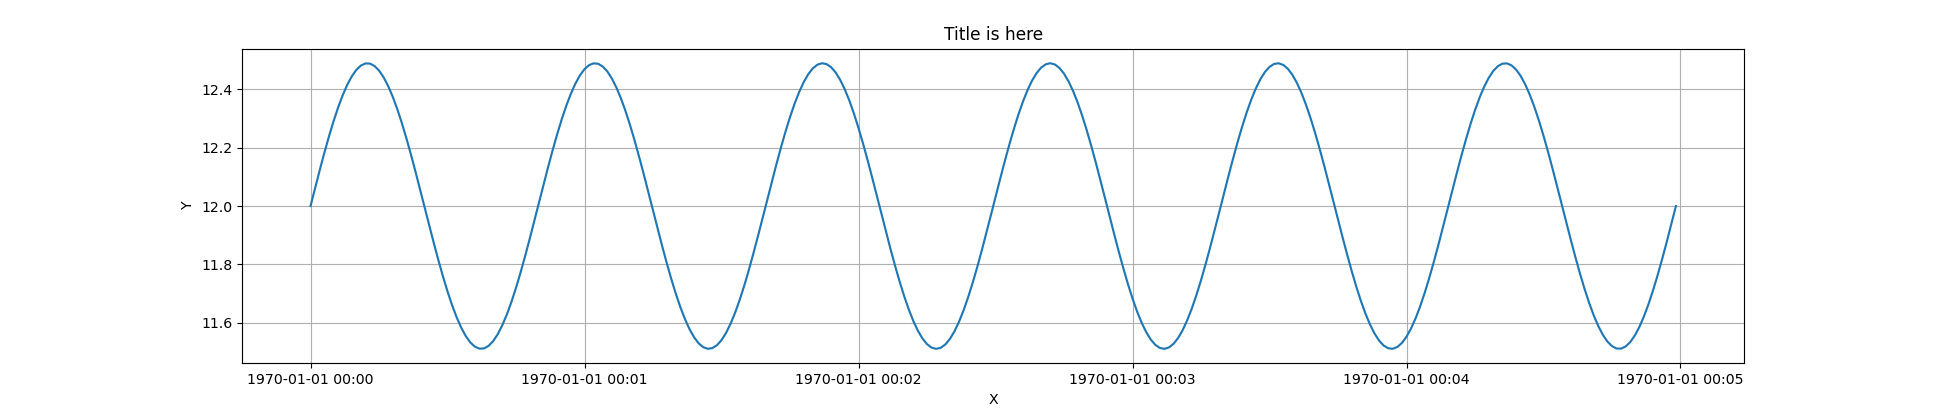

(300, 2)


In [8]:
np.random.seed(RANDOM_SEED)

n_periods = 6
n_period_points = 50
scale = 0.7
bias = 12

error_low=0.0
error_hi=0.0


n_points = n_period_points * n_periods

in_array = np.linspace(-(n_periods) * np.pi, (n_periods) * np.pi, n_points)
dataset = np.sin(in_array) * scale
dataset = dataset + np.random.uniform(low=error_low, high=error_hi, size=(n_points,))
dataset = dataset * scale + bias

raw_data = np.concatenate([dataset.reshape(-1,1), dataset.reshape(-1,1)], axis=1)

data_train = pd.DataFrame(raw_data, columns=["lowest_ask", "highest_bid"], dtype=np.float32)

plot_and_go(data_train, fig_x=19, fig_y=4, dpi=51)